Package
========================

In [16]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import numpy as np
import seaborn as sns

Import dataset
=============================

In [3]:
from tensorflow.keras.datasets import cifar10
(X_train_numpy, Y_train_numpy), (X_test_numpy, Y_test_numpy) = cifar10.load_data()

In [43]:
print(f"{X_train_numpy.shape}, {Y_train_numpy.shape}\n\
{X_test_numpy.shape}, {Y_test_numpy.shape}")

(50000, 32, 32, 3), (50000, 1)
(10000, 32, 32, 3), (10000,)


In [46]:
Y_train_numpy.reshape(50000).shape

(50000,)

In [40]:
label = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 
         5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

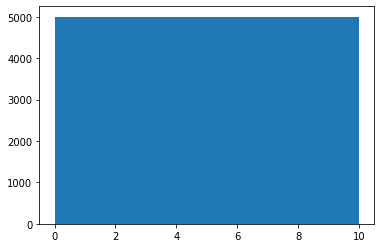

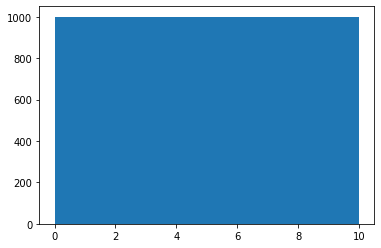

In [49]:
plt.hist(Y_train_numpy.reshape(50000), bins = list(label.keys()) + [10]) 
plt.show()
plt.hist(Y_test_numpy.reshape(10000), bins = list(label.keys()) + [10]) 
plt.show()

In [5]:
X_test = torch.from_numpy(np.rollaxis(X_test_numpy, 3, 1)).type(torch.FloatTensor).div_(255).cuda()
X_train = torch.from_numpy(np.rollaxis(X_train_numpy, 3, 1)).type(torch.FloatTensor).div_(255).cuda()
Y_train = torch.from_numpy(Y_train_numpy).type(torch.long).view(50000).cuda()
Y_test = torch.from_numpy(Y_test_numpy).type(torch.long).view(10000).cuda()

In [6]:
print(f"{Y_train.size()}, {Y_test.size()}\n\
{X_train.size()}, {X_test.size()}")

torch.Size([50000]), torch.Size([10000])
torch.Size([50000, 3, 32, 32]), torch.Size([10000, 3, 32, 32])


MLP
==================

## MLP2
----------------------

In [10]:
class MLP2(nn.Module):
    def __init__(self):
        super(MLP2, self).__init__()
        self.model = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(3 * 32 * 32, 300)),  # hidden layer1
            ('bn1', nn.BatchNorm1d(300)),
            ('relu1', nn.ReLU()),
            ('fc2', nn.Linear(300, 100)),  # hidden layer2
            ('bn2', nn.BatchNorm1d(100)),
            ('relu2', nn.ReLU()),
            ('fc3', nn.Linear(100, 10)), # output layer
            ('softmax1', nn.Softmax(dim=1))
        ]))
        self.ce = nn.CrossEntropyLoss()
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x)) # input layer
        x = self.model(x)
        return x

    # x.size(0) = y.size(0)
    def loss(self, x, y):
        loss = self.ce(x, y)
        return loss


Execute and evaluate
========================

train and test
------------------------

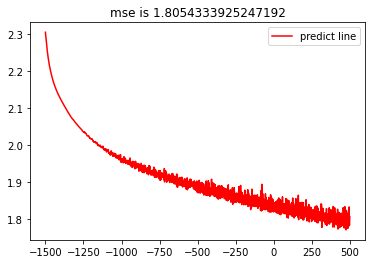

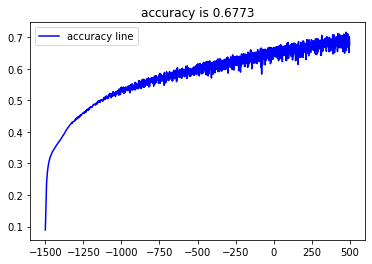

In [20]:
mlp2 = MLP2().cuda()
epoch = 2000
optimizer = optim.SGD(mlp2.parameters(), lr=0.1)
epoch_list = []
loss_list = []
accu_list = []

while(epoch > 0):
    optimizer.zero_grad()
    out = mlp2(X_train)
    loss = mlp2.loss(out, Y_train)
    loss.backward()
    optimizer.step()  # updates parameters

    pred = out.data.max(1, keepdim=False)[1]
    correct = pred.eq(Y_train.data.view_as(pred)).detach().sum()
    correct_rate = correct.detach().item() / X_train.size()[0]

    epoch_list.append((500-epoch))
    loss_list.append(loss.item())
    accu_list.append(correct_rate)

    epoch -= 1

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=loss_list, color='red', label='predict line', ax=ax)
plt.title(f"mse is {loss}")
plt.show()

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=accu_list, color='blue', label='accuracy line', ax=ax)
plt.title(f"accuracy is {correct_rate}")
plt.show()

In [21]:
out = mlp2(X_test)
pred = out.data.max(1, keepdim=False)[1]
correct = pred.eq(Y_test.data.view_as(pred)).detach().sum()
correct_rate = correct.detach().item() / X_test.size()[0]
correct_rate

0.5097

evaluate
-------------------

In [31]:
pred_numpy = pred.cpu().detach().numpy()
Y_test_numpy = Y_test.cpu().detach().numpy()
label_list = list(label.values())

In [35]:
pred_numpy[0:10]

array([5, 9, 0, 7, 4, 6, 1, 6, 5, 1])

In [36]:
Y_test_numpy[0:10]

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])

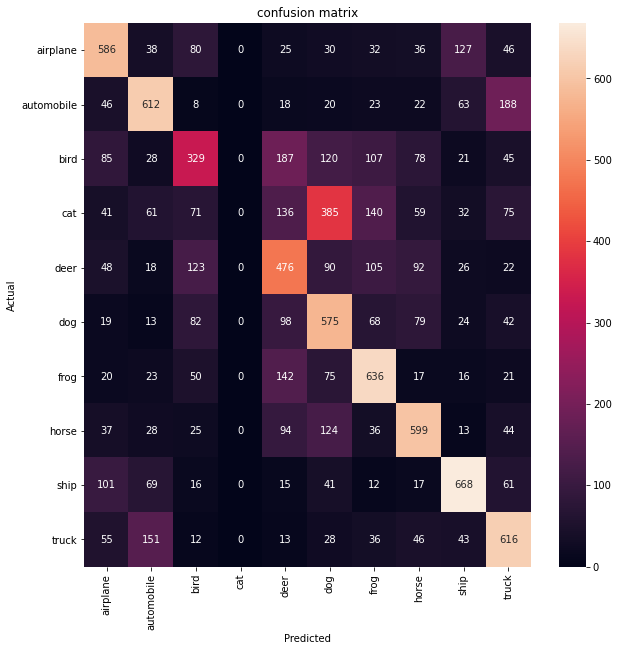

              precision    recall  f1-score   support

    airplane       0.56      0.59      0.58      1000
  automobile       0.59      0.61      0.60      1000
        bird       0.41      0.33      0.37      1000
         cat       0.00      0.00      0.00      1000
        deer       0.40      0.48      0.43      1000
         dog       0.39      0.57      0.46      1000
        frog       0.53      0.64      0.58      1000
       horse       0.57      0.60      0.59      1000
        ship       0.65      0.67      0.66      1000
       truck       0.53      0.62      0.57      1000

    accuracy                           0.51     10000
   macro avg       0.46      0.51      0.48     10000
weighted avg       0.46      0.51      0.48     10000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

conf_mat = confusion_matrix(Y_test_numpy, pred_numpy)
plt.subplots(figsize=(len(label_list), len(label_list)))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('confusion matrix')
plt.show()

print(classification_report(Y_test_numpy, pred_numpy, 
    labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], target_names=label_list))